In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f 
from pyspark.sql.types import FloatType, IntegerType
from pyspark.sql.functions import lit, udf
import matplotlib.pyplot as plt



spark = SparkSession.builder.master('local').getOrCreate()

In [2]:

import os

df = spark.read.options(
    header='True',
    inferSchema='True',
    delimiter=',',
).csv(os.path.expanduser('~/data/DataSample.csv'))
df.printSchema()


root
 |-- _ID: integer (nullable = true)
 |--  TimeSt: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Province: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)



In [3]:
#1
df = df.dropDuplicates([' TimeSt', 'Latitude', 'Longitude'])
df.show()

+-------+--------------------+-------+--------+-------------+--------+----------+
|    _ID|              TimeSt|Country|Province|         City|Latitude| Longitude|
+-------+--------------------+-------+--------+-------------+--------+----------+
|5613403|2017-06-21 00:22:...|     CA|      ON|    Etobicoke| 43.6381|  -79.5787|
|5013924|2017-06-21 00:34:...|     CA|      ON|      Toronto| 43.6606|  -79.4635|
|5122425|2017-06-21 00:42:...|     CA|      AB|      Calgary| 51.1188| -113.9471|
|4571908|2017-06-21 01:01:...|     CA|      AB|      Calgary| 51.0876| -114.0214|
|5447065|2017-06-21 01:08:...|     CA|      ON|      Toronto|43.66341| -79.38597|
|4843104|2017-06-21 01:22:...|     CA|      AB|     Edmonton| 53.4154| -113.4178|
|5030419|2017-06-21 01:36:...|     CA|      AB|      Calgary| 51.0823| -113.9578|
|5337456|2017-06-21 01:57:...|     CA|      QC|   Sainte-Foy| 46.7823|  -71.2882|
|5413296|2017-06-21 02:04:...|     CA|      AB|  Fort Mackay|57.32867|-111.75584|
|4693076|2017-06

In [4]:
df_POI = spark.read.options(
    header='True',
    inferSchema='True',
    delimiter=',',
).csv(os.path.expanduser('~/data/POIList.csv'))
df_POI.printSchema()

root
 |-- POIID: string (nullable = true)
 |--  Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)



In [5]:
#2
POIs     = [0]* df_POI.count()

POI_List = df_POI.collect()

def getMinPOI(lat, long):
    count = 0
    for item in POI_List:
        POIs[count] = abs(lat - item[' Latitude']) + abs(long - item['Longitude'])
        count += 1
    return POIs.index(min(POIs)) + 1

udfPOI = udf(getMinPOI, IntegerType())

df = df.withColumn("POI", udfPOI('Latitude', 'Longitude'))

df.show()






+-------+--------------------+-------+--------+-------------+--------+----------+---+
|    _ID|              TimeSt|Country|Province|         City|Latitude| Longitude|POI|
+-------+--------------------+-------+--------+-------------+--------+----------+---+
|5613403|2017-06-21 00:22:...|     CA|      ON|    Etobicoke| 43.6381|  -79.5787|  3|
|5013924|2017-06-21 00:34:...|     CA|      ON|      Toronto| 43.6606|  -79.4635|  3|
|5122425|2017-06-21 00:42:...|     CA|      AB|      Calgary| 51.1188| -113.9471|  1|
|4571908|2017-06-21 01:01:...|     CA|      AB|      Calgary| 51.0876| -114.0214|  1|
|5447065|2017-06-21 01:08:...|     CA|      ON|      Toronto|43.66341| -79.38597|  3|
|4843104|2017-06-21 01:22:...|     CA|      AB|     Edmonton| 53.4154| -113.4178|  1|
|5030419|2017-06-21 01:36:...|     CA|      AB|      Calgary| 51.0823| -113.9578|  1|
|5337456|2017-06-21 01:57:...|     CA|      QC|   Sainte-Foy| 46.7823|  -71.2882|  3|
|5413296|2017-06-21 02:04:...|     CA|      AB|  Fort 

In [6]:
#Storing the distances to each POI
POIs     = [0]* df_POI.count()

def getPOIDist(lat, long):
    count = 0
    for item in POI_List:
        POIs[count] = abs(lat - item[' Latitude']) + abs(long - item['Longitude'])
        count += 1
    return min(POIs)

udfPOI = udf(getPOIDist, FloatType())

df = df.withColumn("Distances", udfPOI('Latitude', 'Longitude'))

df.show()

+-------+--------------------+-------+--------+-------------+--------+----------+---+---------+
|    _ID|              TimeSt|Country|Province|         City|Latitude| Longitude|POI|Distances|
+-------+--------------------+-------+--------+-------------+--------+----------+---+---------+
|5613403|2017-06-21 00:22:...|     CA|      ON|    Etobicoke| 43.6381|  -79.5787|  3| 7.896205|
|5013924|2017-06-21 00:34:...|     CA|      ON|      Toronto| 43.6606|  -79.4635|  3| 7.758505|
|5122425|2017-06-21 00:42:...|     CA|      AB|      Calgary| 51.1188| -113.9471|  1| 2.888733|
|4571908|2017-06-21 01:01:...|     CA|      AB|      Calgary| 51.0876| -114.0214|  1| 2.994233|
|5447065|2017-06-21 01:08:...|     CA|      ON|      Toronto|43.66341| -79.38597|  3| 7.678165|
|4843104|2017-06-21 01:22:...|     CA|      AB|     Edmonton| 53.4154| -113.4178|  1| 0.198701|
|5030419|2017-06-21 01:36:...|     CA|      AB|      Calgary| 51.0823| -113.9578|  1| 2.935933|
|5337456|2017-06-21 01:57:...|     CA|  

In [8]:
#3a average
_df    = df.toPandas()
POI_pd = df_POI.toPandas()


POISums      = [0] * df_POI.count()
POICounts    = [0] * df_POI.count()

for index in _df.index:
    POISums  [ int(_df['POI'][index]) - 1] += _df['Distances'][index]
    POICounts[ int(_df['POI'][index]) - 1] += 1
    
i = 0
for index in POI_pd.index:
    if POICounts[i] != 0:    
        POI_pd.loc[index, 'AverageDist'] = POISums[i] / POICounts[i]
    i += 1
display(_df)

,_ID,TimeSt,Country,Province,City,Latitude,Longitude,POI,Distances
0,5613403,2017-06-21 00:22:52.957,CA,ON,Etobicoke,43.63810,-79.57870,3,7.896205
1,5013924,2017-06-21 00:34:42.930,CA,ON,Toronto,43.66060,-79.46350,3,7.758505
2,5122425,2017-06-21 00:42:26.647,CA,AB,Calgary,51.11880,-113.94710,1,2.888733
3,4571908,2017-06-21 01:01:56.140,CA,AB,Calgary,51.08760,-114.02140,1,2.994233
4,5447065,2017-06-21 01:08:08.113,CA,ON,Toronto,43.66341,-79.38597,3,7.678165
...,...,...,...,...,...,...,...,...,...
19994,4591571,2017-06-21 22:03:15.590,CA,ON,Richmond Hill,43.89390,-79.43750,3,7.499205
19995,4756930,2017-06-21 22:15:43.223,CA,AB,Edmonton,53.50460,-113.45300,1,0.074301
19996,5576647,2017-06-21 22:19:34.327,CA,ON,Kirkland Lake,48.15160,-80.03220,3,9.096147
19997,4970768,2017-06-21 22:32:25.367,CA,QC,Brossard,45.46930,-73.48480,3,0.133553


In [9]:
#3a stdev
i = 1.0
for index in POI_pd.index:
    POI_pd.loc[index, 'Stdev'] = (_df[_df.POI == i]['Distances']).std()
    i += 1

display(POI_pd)

,POIID,Latitude,Longitude,AverageDist,Stdev
0,POI1,53.546167,-113.485734,4.139484,4.820067
1,POI2,53.546167,-113.485734,NaN,NaN
2,POI3,45.521629,-73.566024,6.845424,3.486674
3,POI4,45.224830,-63.232729,10.323584,32.853840


POI1: Radius = 226.8665313720703, Density = 2.9542852425096133
POI2: Radius = 226.8665313720703, Density = 0.0
POI3: Radius = 226.8665313720703, Density = 5.642737565176683
POI4: Radius = 226.8665313720703, Density = 0.0029948484572461824


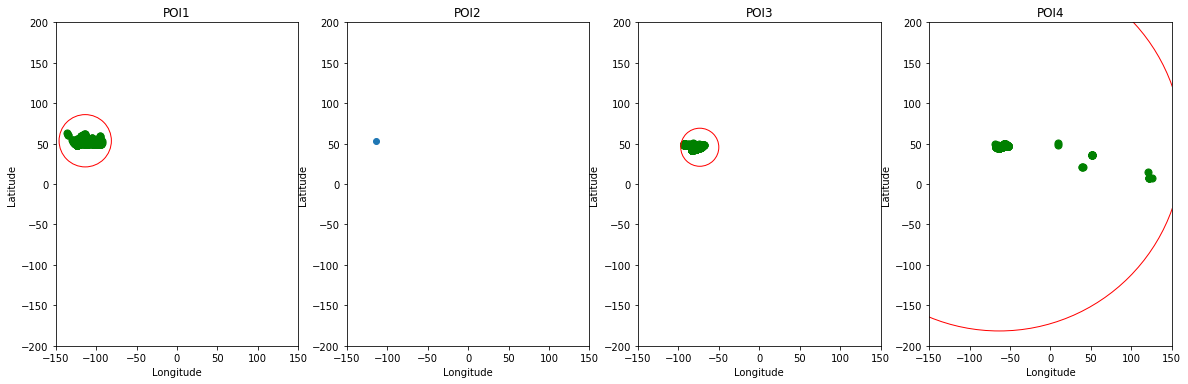

In [41]:
#3b

density = [0.0] * POI_pd.count()
radius  = [0.0] * POI_pd.count()

figure = plt.figure(figsize=(20,20))
for i, (name,row) in enumerate(POI_pd.iterrows()):
    ax = plt.subplot(1,4, i +1)
    ax.set_title("POI" + str(i + 1))
    ax.set_aspect('equal')
    ax.scatter(y = row[' Latitude'],x = row['Longitude'])
    
    _df[_df.POI == i + 1].plot.scatter(ax = ax, y='Latitude', x ='Longitude', s = 50, color = 'g')
    
    if _df[_df.POI == i + 1]['Distances'].count() > 0:
        radius[i] = _df[_df.POI == i + 1]['Distances'].max()
    circle = plt.Circle(( row['Longitude'], row[' Latitude']), radius[i], color ='r', fill = False)
    ax.add_patch(circle)
    
    plt.gca().set_xlim(-150,150)
    plt.gca().set_ylim(-200,200)
    
    PI = 3.14
    area = PI * radius[i] * radius[i]
    if _df[_df.POI == i + 1]['Distances'].count() > 0:
        density[i] = _df[_df.POI == i + 1]['Distances'].count() / area
    else:
        density[i] = 0
    
    print("POI" + str(i + 1) + ": Radius = " + str(maxVal) + ", Density = " + str(density[i]))


plt.show()

In [39]:
i = 0
for row in POI_pd.index:
    POI_pd.loc[row, 'Density'] = density[i]
    i += 1
    
display(POI_pd)

,POIID,Latitude,Longitude,AverageDist,Stdev,Density
0,POI1,53.546167,-113.485734,4.139484,4.820067,2.954285
1,POI2,53.546167,-113.485734,NaN,NaN,0.000000
2,POI3,45.521629,-73.566024,6.845424,3.486674,5.642738
3,POI4,45.224830,-63.232729,10.323584,32.853840,0.002995


In [50]:
#4a) 1

lowerBound = POI_pd['Density'].min()
upperBound = POI_pd['Density'].max()
scaleMin = -10
scaleMax = 10

slope = (scaleMax - scaleMin) / (upperBound - lowerBound)
#for index in POI_pd.index:
for index in POI_pd.index:
    POI_pd.loc[index, 'Popularity'] = scaleMin + slope *(POI_pd.loc[index,'Density'] - lowerBound)
    
display(POI_pd)

,POIID,Latitude,Longitude,AverageDist,Stdev,Density,Popularity
0,POI1,53.546167,-113.485734,4.139484,4.820067,2.954285,0.471106
1,POI2,53.546167,-113.485734,NaN,NaN,0.000000,-10.000000
2,POI3,45.521629,-73.566024,6.845424,3.486674,5.642738,10.000000
3,POI4,45.224830,-63.232729,10.323584,32.853840,0.002995,-9.989385
